# Generate a lens using <span style="font-family:Consolas; font-size:1em;">lenstronomy</span>

In [1]:
# Global imports
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf

from lenstronomy.SimulationAPI.simulations import Simulation
from lenstronomy.Data.imaging_data import Data
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Util import util
from lenstronomy.Util import param_util

%matplotlib inline

In [2]:
# FITS paths
psf_path = "tinytim_WFC3_IR_F160W/result00.fits"
source_path = "SLIT_images/source.fits"

In [3]:
# data specifics
num_pix = 100  # cutout pixel size
delta_pix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)

_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
            = util.make_grid_with_coordtransform(numPix=num_pix, 
                                                 deltapix=delta_pix,
                                                 subgrid_res=1,
                                                 inverse=False)
kwargs_data = {'numPix': num_pix,
               'ra_at_xy_0': ra_at_xy_0,
               'dec_at_xy_0': dec_at_xy_0, 
               'transform_pix2angle': Mpix2coord}
data_class = Data(kwargs_data)

# PSF specifics
psf_type = 'gaussian' # 'gaussian' or 'from_image'
fwhm_gaussian = 0.3  # full width half max of PSF, in case of a gaussian kernel
if psf_type == 'from_image':
    # PSF kernel from an image
    kernel = pf.open(psf_path)[0].data
    #kernel = kernel[:-1,:-1]
    print(kernel.shape)
    kwargs_psf = {'psf_type': 'PIXEL', 'pixel_sikernel_point_source': kernel}
else:
    kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_gaussian, 'pixel_size': delta_pix}
    
psf_class = PSF(kwargs_psf)

In [4]:
# Models configuration
# lens mass model
lens_model_list = ['SPEMD', 'SHEAR']
#lens_model_list = ['SIE']
kwargs_shear = {'e1': 0.01, 'e2': 0.02, 'ra_0': 0, 'dec_0': 0}
kwargs_spemd = {'theta_E': 25*delta_pix, 
                'gamma': 2.0, # so it is a SIE profile
                'center_x': 0, 
                'center_y': 0,
                'e1': 0,
                'e2': 0}
#kwargs_sie = {'theta_E': 25, 
#              'center_x': 0., 
#              'center_y': 0.,
#              'e1': param_util.phi_q2_ellipticity(phi=2, q=0.7)[0],
#              'e2': param_util.phi_q2_ellipticity(phi=2, q=0.7)[1]}
#b = 30
#xc = 1
#q = 0.7
#betata = 2
#thetata = 25
#center_x, center_y = nt1/2.+50, nt2/2.+50

kwargs_lens = [kwargs_spemd, kwargs_shear]
#kwargs_lens = [kwargs_sie]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# lens light profile
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_sersic_ellipse_lens = {'amp': 8, 
                              'R_sersic': 5,
                              'n_sersic': 2, 
                              'center_x': 0., 
                              'center_y': 0., 
                              'e1': 0.2, 
                              'e2': 0.1}
kwargs_lens_light = [kwargs_sersic_ellipse_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# source light profile
ra_center_source, dec_center_source = -0.05, 0.03
#source_light_model_list = ['SERSIC_ELLIPSE', 'SHAPELETS']
source_light_model_list = ['FROM_FILE']
kwargs_sersic_ellipse_source = {'amp': 6, 
                                'R_sersic': 0.3,
                                'n_sersic': 3, 
                                'center_x': ra_center_source, 
                                'center_y': dec_center_source, 
                                'e1': -0.1, 
                                'e2': 0.2}
n_max_shapelets = 8
num_param_shapelets = int((n_max_shapelets+1)*(n_max_shapelets+2)/2)
amp_shapelets = 10 * np.random.randn(num_param_shapelets)
kwargs_shapelets_source = {'beta': 0.1,
                           'center_x': ra_center_source,
                           'center_y': dec_center_source,
                           'n_max': n_max_shapelets,
                           'amp': amp_shapelets}
kwargs_fromfile_source = {'center_x': 0,
                          'center_y': 0}
# kwargs_source_light = [kwargs_sersic_ellipse_source, kwargs_shapelets_source]
kwargs_source_light = [kwargs_fromfile_source]

kwargs_fromfile = {'file_path': source_path, 'data_class': data_class}

source_light_model_class = LightModel(light_model_list=source_light_model_list, **kwargs_fromfile)

In [5]:
# point sources, after solving the lens equation from source plane quasar position
# here we set the quasar position to be aligned with its host galaxy
ra_quasar_source, dec_quasar_source = ra_center_source, dec_center_source
num_images = 4

lensEquationSolver = LensEquationSolver(lens_model_class)
ra_quasar_images, dec_quasar_images = lensEquationSolver.findBrightImage(
    ra_quasar_source, dec_quasar_source, kwargs_lens, numImages=num_images, 
    min_distance=delta_pix, search_window=num_pix*delta_pix)

mag = lens_model_class.magnification(ra_quasar_images, dec_quasar_images, kwargs=kwargs_lens)
kwargs_ps_tmp = {
    'ra_image': ra_quasar_images, 
    'dec_image': dec_quasar_images,
    'point_amp': np.abs(mag) * 100
}
kwargs_ps = [] #[kwargs_ps_tmp]
point_source_list = [] # ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list)

In [6]:
# "numerics"
kwargs_numerics = {'subgrid_res': 1, 'psf_subgrid': False}

In [7]:
# initialize the Image model class by combining the modules we created above
imageModel = ImageModel(data_class=data_class, psf_class=psf_class, lens_model_class=lens_model_class,
                        source_model_class=source_light_model_class,
                        lens_light_model_class=lens_light_model_class,
                        point_source_class=point_source_class, 
                        kwargs_numerics=kwargs_numerics)

# simulate image with the parameters we have defined above
image_no_noise = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_source_light,
                                  kwargs_lens_light=kwargs_lens_light, kwargs_ps=kwargs_ps,
                                  source_add=True, lens_light_add=False, point_source_add=True,
                                  unconvolved=False)

# we can also add noise
import lenstronomy.Util.image_util as image_util
sigma_bkg = 0.001  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
poisson = image_util.add_poisson(image_no_noise, exp_time=exp_time)
bkg = image_util.add_background(image_no_noise, sigma_bkd=sigma_bkg)
image_final = image_no_noise + bkg + poisson

data_class.update_data(image_final)


# get the source only, in a lensed or de-lensed version
image_source = imageModel.source_surface_brightness(
    kwargs_source_light, kwargs_lens, de_lensed=True, unconvolved=True)
print(image_source.shape)

(100, 100)


/Users/aymericg/anaconda2/envs/pystro3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


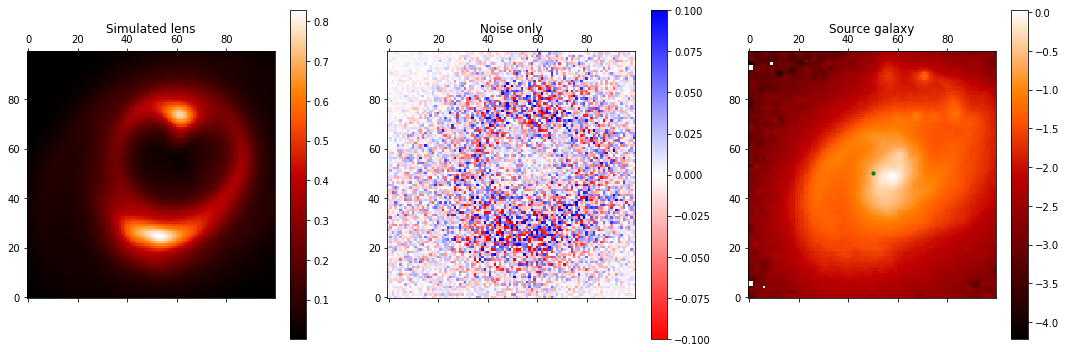

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
ax.set_title("Simulated lens")
im = ax.matshow(image_no_noise, origin='lower', cmap='gist_heat')
#ax.scatter(numPix/2., numPix/2., color='blue', marker='.', s=40, alpha=0.5) # center of the image
fig.colorbar(im, ax=ax)

ax = axes[1]
ax.set_title("Noise only")
im = ax.matshow(image_final - image_no_noise, origin='lower', cmap='bwr_r', vmin=-0.1, vmax=0.1)
fig.colorbar(im, ax=ax)

ax = axes[2]
ax.set_title("Source galaxy")
im = ax.matshow(np.log10(image_source), origin='lower', cmap='gist_heat')
ax.scatter(num_pix/2., num_pix/2., color='green', marker='.', s=40) # center of the image
fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()